In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# стандартизация
from sklearn.preprocessing import StandardScaler

# метрики
from sklearn.metrics import (accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay)

import warnings
warnings.filterwarnings('ignore')

/home/w_lander/anaconda3/envs/dowgrade/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Используя diabetes-dataset, выполните следующие шаги:

1. Предварительная обработка данных:
* Очистите данные от пропусков (если они есть), обработайте аномалии и нормализуйте данные, если это необходимо.
* Разделите датасет на обучающую и тестовую выборки.

### О наборе данных

Этот набор данных изначально был получен из Национального института диабета, заболеваний пищеварительной системы и почек. Целью является прогнозирование на основе диагностических измерений наличия у пациента диабета.

Содержание
На выборку этих случаев из более обширной базы данных накладывалось несколько ограничений. В частности, все пациенты здесь — женщины в возрасте не менее 21 года индейского происхождения Пима.

* Pregnancies - Беременности: Количество беременностей
* Глюкоза: концентрация глюкозы в плазме через 2 часа в оральном тесте на толерантность к глюкозе
* BloodPressure - Кровяное давление: диастолическое артериальное давление (мм рт. ст.)
* SkinThickness - Толщина кожной складки трицепса (мм)
* Insulin - Инсулин: 2-часовой сывороточный инсулин (мю Ед/мл)
* BMI - ИМТ: Индекс массы тела (вес в кг/(рост в м)^2)
* DiabetesPedigreeFunction - Функция родословной диабета
* Age - Возраст: Возраст (лет)
* Outcome - Результат: переменная класса (0 или 1)

In [2]:
df_deabet = pd.read_csv('data/diabetes-dataset.csv')
df_deabet.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [3]:
df_deabet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB


In [4]:
df_deabet.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
df_deabet.duplicated().sum()
# В данном случае мы не можем счтитать эти данные дубликатами, т.к они не указывают на конкретного человека.

1256

In [6]:
df_deabet['Outcome'].value_counts()

Outcome
0    1316
1     684
Name: count, dtype: int64

In [7]:
print('Имеем дисбаланс класов')

Имеем дисбаланс класов


In [8]:
df_deabet.describe().round(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000
mean,3.704,121.182,69.146,20.935,80.254,32.193,0.471,33.090,0.342
std,3.306,32.069,19.188,16.103,111.181,8.150,0.324,11.786,0.474
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,63.500,0.000,0.000,27.375,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,40.000,32.300,0.376,29.000,0.000
75%,6.000,141.000,80.000,32.000,130.000,36.800,0.624,40.000,1.000
max,17.000,199.000,122.000,110.000,744.000,80.600,2.420,81.000,1.000


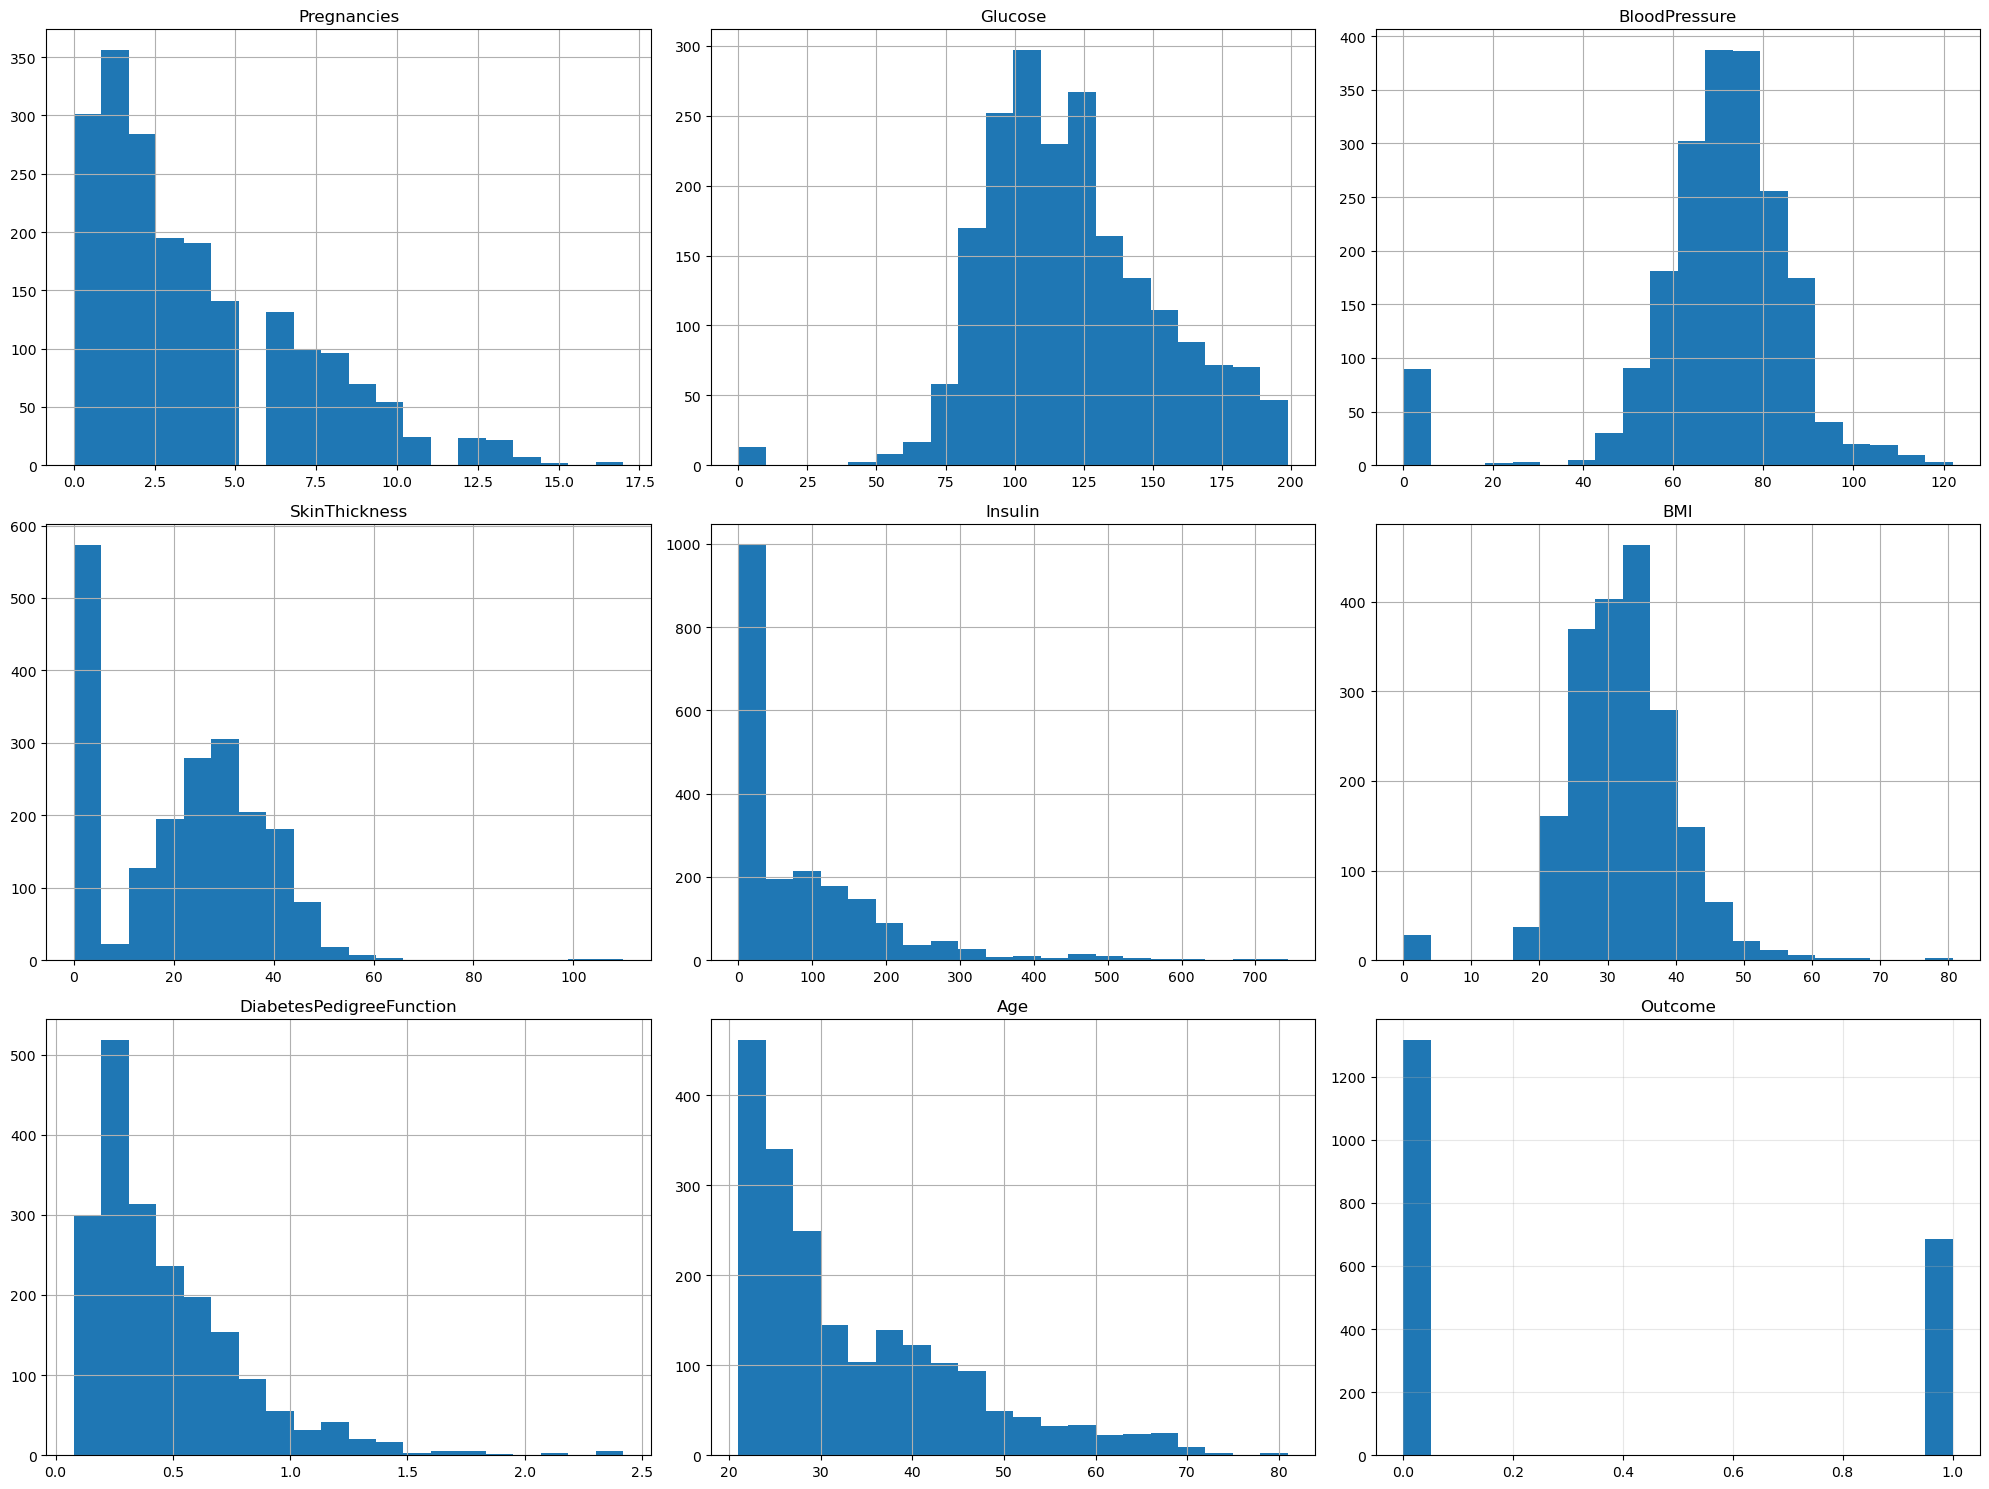

In [9]:
# Генерирует гистограммы для всех числовых столбцов в DataFrame
df_deabet.hist(figsize=(20, 15), bins=20)
plt.tight_layout() # Улучшает размещение подграфиков чтобы они не пересекались
plt.grid(alpha=0.3)
plt.show()

#### Судя по графику Глюкозы, часть данных со значением 0, что свидетельствует об ошибке. Заполним 0-вые значения медианной

In [10]:
df_deabet.loc[df_deabet['Glucose'] == 0, 'Glucose'] = df_deabet['Glucose'].median()

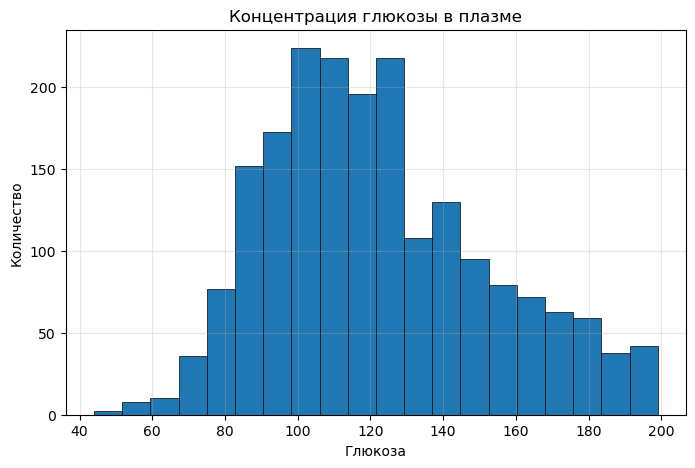

In [11]:
plt.figure(figsize=(8,5))

df_deabet['Glucose'].hist(bins=20, linewidth=0.5, edgecolor='k')
plt.title('Концентрация глюкозы в плазме')
plt.ylabel('Количество')
plt.xlabel('Глюкоза')

plt.grid(alpha=0.3)
plt.show()

#### Также на графике с Кровянным давлением имеется наблюдения с аномальными значениями менее 60. Заменим их на медианну

In [12]:
df_deabet.loc[df_deabet['BloodPressure'] < 60, 'BloodPressure'] = df_deabet['BloodPressure'].median()

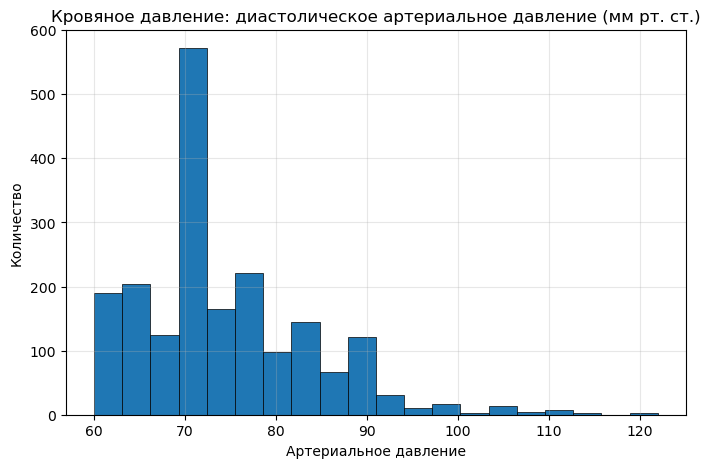

In [13]:
plt.figure(figsize=(8,5))

df_deabet['BloodPressure'].hist(bins=20, linewidth=0.5, edgecolor='k')
plt.title('Кровяное давление: диастолическое артериальное давление (мм рт. ст.)')
plt.ylabel('Количество')
plt.xlabel('Артериальное давление')
plt.grid(alpha=0.3)
plt.show()

#### На графике с Индексом массы тела, есть чать наблюдений со значением 0. Заменим их также на медианну

In [14]:
df_deabet.loc[df_deabet['BMI'] == 0, 'BMI'] = df_deabet['BMI'].median()

In [15]:
df_deabet.describe().round(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000
mean,3.704,121.943,74.538,20.935,80.254,32.645,0.471,33.090,0.342
std,3.306,30.536,9.515,16.103,111.181,7.190,0.324,11.786,0.474
min,0.000,44.000,60.000,0.000,0.000,18.200,0.078,21.000,0.000
25%,1.000,99.000,68.000,0.000,0.000,27.600,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,40.000,32.300,0.376,29.000,0.000
75%,6.000,141.000,80.000,32.000,130.000,36.800,0.624,40.000,1.000
max,17.000,199.000,122.000,110.000,744.000,80.600,2.420,81.000,1.000


#### Построим матрицу корреляции для выявления линейной зависимоти

In [16]:
# подготовим признаки
df_corr = df_deabet

In [17]:
corr_matrix = df_corr.corr()
corr_matrix = np.round(corr_matrix, 1)
corr_matrix[np.abs(corr_matrix) < 0.1] = 0

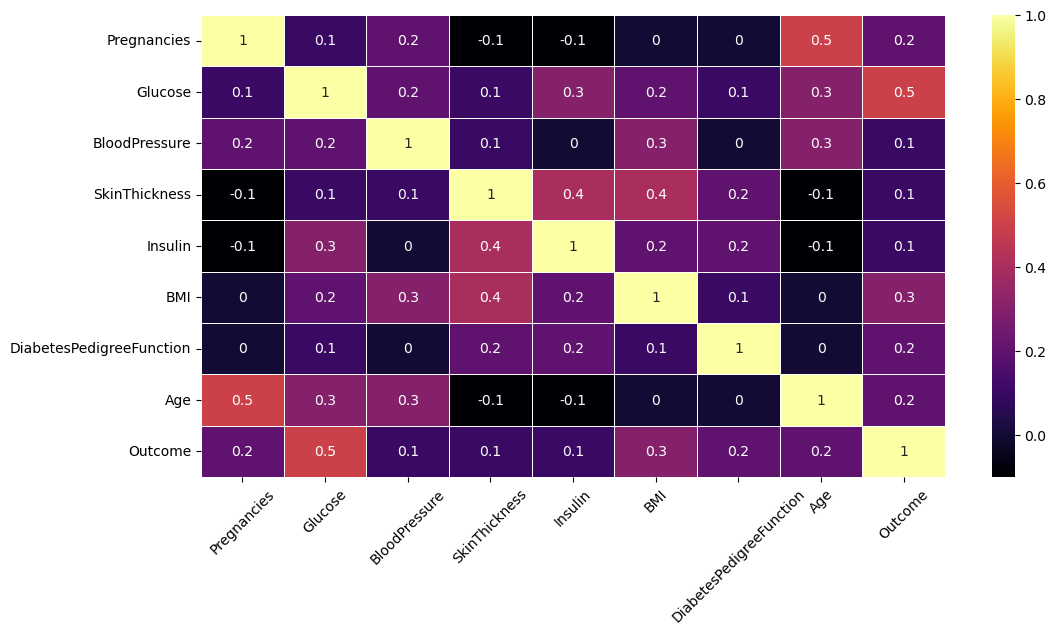

In [18]:
plt.figure(figsize=(12, 6))

sns.heatmap(corr_matrix, annot=True, linewidths=0.7, cmap='inferno')
plt.xticks(rotation=45)
#plt.yticks(rotation=35)
plt.show()

- Сильная положительная корреляция (0.5) 'Outcome' и 'Glucose'.
- Сильная положительная корреляция (0.4) 'BMI' и 'SkinThickness'.
- Слабая положительная корреляция (0.3) 'Outcome' и 'BMI'.
- Слабая положительная корреляция (0.3) 'BloodPressure' и 'BMI'.
- Слабая положительная корреляция (0.3) 'Glicose' и 'Age'.

In [19]:
feature_names_for_stand = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
#feature_names_for_stand = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Age']

In [20]:
# Предварительная обработка данных
scaler = StandardScaler()
stand_features = scaler.fit_transform(df_deabet[feature_names_for_stand])

In [21]:
df_deabet[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [22]:
#df_deabet = df_deabet[['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Age', 'Outcome']]

In [23]:
df_deabet.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-0.515394,0.525974,-1.318039,0.873645,-0.722016,0.132824,-1.063246,1.180424,1
1,-1.120495,-1.242888,0.784516,0.625186,0.402563,0.772739,-0.735551,-0.856326,0
2,-1.120495,0.755271,-0.266762,-1.300374,-0.722016,1.607411,0.491759,-0.177409,1
3,-1.120495,0.427704,-0.687273,1.308449,1.527142,1.343098,-0.327478,-0.771462,1
4,-0.817945,0.558731,-1.318039,1.246334,3.596367,1.120519,0.201161,-1.026055,0


#### Сохраним полученный датасет

In [24]:
df_deabet.to_csv('data/stand_diabetes-dataset.csv', index=False, encoding='utf8')

#### Построение модели

In [25]:
X = df_deabet[feature_names_for_stand]
y = df_deabet['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [26]:
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.75      0.81       389
           1       0.64      0.80      0.71       211

    accuracy                           0.77       600
   macro avg       0.75      0.77      0.76       600
weighted avg       0.79      0.77      0.77       600



In [27]:
from sklearn.svm import SVC

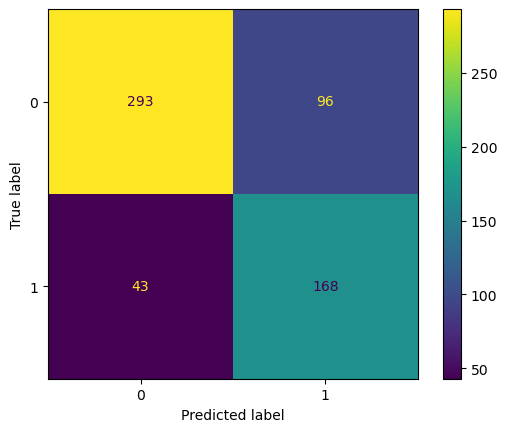

In [28]:
clf = SVC(random_state=42)
clf.fit(X_train, y_train)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

disp.plot()
plt.show()

In [29]:
model = LogisticRegression(class_weight={0:1, 1:1.8}, random_state=42)
model.fit(X_train, y_train)

predicted_valid = model.predict(X_test)
print(classification_report(y_test, predicted_valid))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83       389
           1       0.67      0.78      0.72       211

    accuracy                           0.79       600
   macro avg       0.77      0.78      0.77       600
weighted avg       0.80      0.79      0.79       600



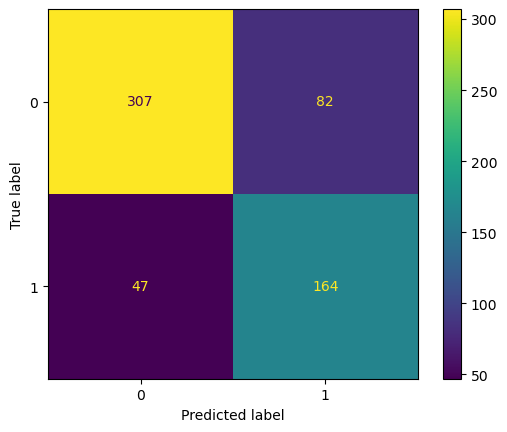

In [30]:
clf = SVC(random_state=42)
clf.fit(X_train, y_train)
cm = confusion_matrix(y_test, predicted_valid, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

disp.plot()
plt.show()